# Pre-trainer Visualization

Visualize the results from the pre-trainer inference on random dataset images.

Start by importing the model builder and building the model with the previously trained weights.

In [1]:
import sys
sys.path.append("../")
from multitudinous.utils.model_builder import build_img_pretraining
import torch

# build the model
model = build_img_pretraining("resnet50_ae", 4, "../resnet50_ae/img_pretrainer_15.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

# print the model
print(model)

ResNet50AE(
  (encoder): ResNet50(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout2d(p=0.5, inplace=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout2): Dropout2d(p=0.5, inplace=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Now we need to import the dataset builder and build the dataset.

In [2]:
from multitudinous.utils.dataset_builder import build_img_dataset
from torch.utils.data import DataLoader

# build the dataset
train_set, _, _ = build_img_dataset("tum_rgbd", "../../data/tum_rgbd1", "train", "val", "test")

# create the dataloader
dataloader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

Now, run inference and visualize on "x" random samples from the dataset.

Sample 1/100 - RMSE: 0.028282485902309418, Abs Rel: 0.0884145200252533, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0 

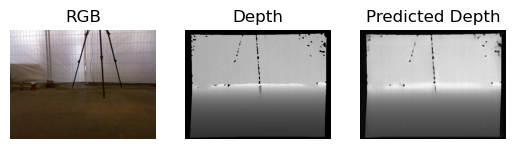

Sample 2/100 - RMSE: 0.03689746558666229, Abs Rel: 0.08958101272583008, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0 

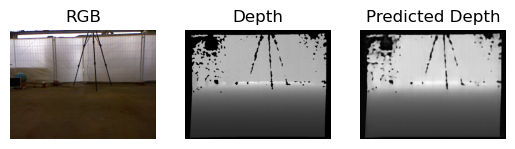

Sample 3/100 - RMSE: 0.04005809128284454, Abs Rel: 0.08868870139122009, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0 

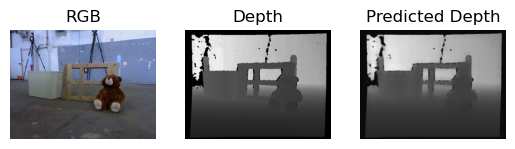

Sample 12/100 - RMSE: 0.040119778364896774, Abs Rel: 0.0825120136141777, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0  

In [3]:
import matplotlib.pyplot as plt
import torch
from multitudinous.loss_fns import rmse, rel, delta

NUM_VIZ_SAMPLES = 3
FIXED_VIZ_SAMPLE = 70 # number of the always visualized sample
NUM_EVAL_SAMPLES = 100

visualized_count = 0

rmse_total = 0
abs_rel_total = 0
delta1_total = 0
delta2_total = 0
delta3_total = 0
count = 0
total_samples = len(dataloader)

# run inference on the samples
for rgb, depth in dataloader:

    pred = None

    # build the rgb-d sample
    rgb = rgb.to(device)
    depth = depth.to(device)
    depth = depth.unsqueeze(1)
    rgbd = torch.cat((rgb, depth), dim=1)
    
    # run inference
    with torch.no_grad():
        # move the sample to the device
        pred = model(rgbd)

        # calculate the metrics
        pred = pred.squeeze()
        depth = depth.squeeze()

        rmse_total += rmse(pred, depth)
        abs_rel_total += rel(pred, depth)
        delta1_total += delta(pred, depth, 1.25)
        delta2_total += delta(pred, depth, 1.25**2)
        delta3_total += delta(pred, depth, 1.25**3)

    count += 1

    print(f"\rSample {count}/{NUM_EVAL_SAMPLES} - RMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}", end=" ")

    if count >= NUM_EVAL_SAMPLES:
        break

    # ----------------------
        
    # visualize the results
    if visualized_count < NUM_VIZ_SAMPLES:

        visualized_count += 1

        rgb = rgb.squeeze()

        # plot the results
        plt.subplot(1, 3, 1)
        plt.imshow(rgb.permute(1, 2, 0).cpu())
        plt.title("RGB")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(depth.squeeze(0).cpu(), cmap="gray")
        plt.title("Depth")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze().detach().cpu(), cmap="gray")
        plt.title("Predicted Depth")
        plt.axis("off")
        plt.show()

    if count == FIXED_VIZ_SAMPLE:

        rgb = rgb.squeeze()

        # plot the colour image
        plt.imshow(rgb.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.show()

        # plot the ground truth
        plt.imshow(depth.squeeze(0).cpu(), cmap="gray")
        plt.axis("off")
        plt.show()

        # plot the prediction
        plt.imshow(pred.squeeze().detach().cpu(), cmap="gray")
        plt.axis("off")
        plt.show()

    del pred, rgb, depth

# clean up
del model, dataloader

# print the metrics
print(f"\nRMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}")